In [5]:
# Автоматическая перезагрузка модулей при изменении
# Позволяет обновлять код в helper.py, plots.py, nlp.py без перезапуска ядра
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Импорт библиотек для машинного обучения и обработки текста
import pandas as pd
import numpy as np
import random
import re

# Импорт sklearn для классических алгоритмов ML
from sklearn.model_selection import train_test_split, StratifiedKFold  # разделение данных и кросс-валидация
from sklearn.dummy import DummyClassifier  # наивный классификатор для бейслайна
from sklearn.compose import ColumnTransformer  # трансформация разных столбцов по-разному
from sklearn.pipeline import Pipeline  # создание пайплайнов обработки
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer  # векторизация текста
from sklearn.linear_model import LogisticRegression  # логистическая регрессия
from sklearn.tree import DecisionTreeClassifier  # дерево решений
from sklearn.ensemble import RandomForestClassifier  # случайный лес
from sklearn.base import clone  # клонирование моделей
from lightgbm import LGBMClassifier  # градиентный бустинг
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import FunctionTransformer

# Пользовательские модули
from helper import *  # вспомогательные функции
from plots import *   # функции визуализации
from nlp import *     # функции обработки естественного языка
from transformers import *  # функции для работы с трансформерами

In [7]:
# Фиксация состояния генератора псевдослучайных чисел для воспроизводимости
# Критически важно для машинного обучения - результаты должны быть воспроизводимы
SEED = 42 # можно указать любое число
np.random.seed(SEED)  # для numpy операций
random.seed(SEED)     # для стандартного модуля random

In [ ]:
# Загружаем данные
df = pd.read_csv('imdb.csv')

In [9]:
#Можно заметить наличие html тегов, которые надо удалить
df.iloc[1,0]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [10]:
word_length = df['review'].apply(lambda x: len(x.split())).sort_values(ascending = True)
np.quantile(word_length, [0.05, 0.25, 0.5, 0.75, 0.95])

array([ 63., 126., 173., 280., 590.])

## 5. Препроцессинг данных

**Цель:** Подготовить данные для обучения моделей классического машинного обучения.
Включает очистку данных, токенизацию и создание признаков.

### 5.1 Общие преобразования

**Логика:** Приводим данные к стандартному формату для машинного обучения:
- Удаляем ненужные столбцы
- Очищаем от неинформативных записей и html тегов
- Токенизируем тексты для дальнейшей векторизации

In [11]:
# Создаем копию данных для предобработки
df_preprocessed = df.copy()

# Преобразуем целевую переменную в числовой формат
df_preprocessed['is_positive'] = df_preprocessed['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# # Токенизируем тексты с помощью tiktoken (токенизатор GPT)
# # Это необходимо для дальнейшей векторизации текстов
df_preprocessed['review'] = df_preprocessed['review'].apply(tokenize_tiktoken)


In [12]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X, y = divide_data(df_preprocessed, 'is_positive')

## 6. Построение baseline

**Цель:** Создать базовые модели для сравнения с более сложными подходами.
Baseline показывает минимальный уровень качества, которого нужно достичь или превзойти.

In [13]:
# Определяем набор baseline моделей для сравнения:
models = [
    ('DummyClassifier', DummyClassifier(random_state=SEED, strategy='most_frequent')),  # наивный классификатор
    ('LogisticRegression', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')),  # линейная модель
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4)),  # дерево решений
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED, n_jobs = -1)),  # случайный лес
    ('LGBMClassifier', LGBMClassifier(random_state=SEED, verbose=-1))  # градиентный бустинг
]

In [14]:
# Настраиваем стратифицированную кросс-валидацию с 5 фолдами
# StratifiedKFold гарантирует, что в каждом фолде будет примерно одинаковое соотношение классов
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

### 6.1. CountVectorizer

**Логика:** CountVectorizer создает матрицу частот слов (bag of words).
Каждая ячейка содержит количество вхождений конкретного слова в документ.
Это простой, но эффективный способ представления текста для классических ML алгоритмов.

#### 6.1.1 Без очистки токенов

**Цель:** Проверить базовое качество с исходными токенами.
Это отправная точка для сравнения с очищенными версиями.

In [15]:
# Создаем пайплайн для векторизации текстов
count_vectorizer_preprocessor = Pipeline([
    ('vectorizer', ColumnTransformer(
        [
            # Векторизация описаний: analyzer=lambda x: x означает, что вход уже токенизирован
            # Векторизация описаний: min_df=50 исключает слова, встречающиеся менее 50 раз
            ('vectorizer', CountVectorizer(analyzer=lambda x: x, min_df=50, dtype=np.float32), 'review')
        ],
        remainder='drop',  # остальных столбцов нет, можно выкинуть 
        verbose_feature_names_out=True  # для отладки имен признаков
    )),
])

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

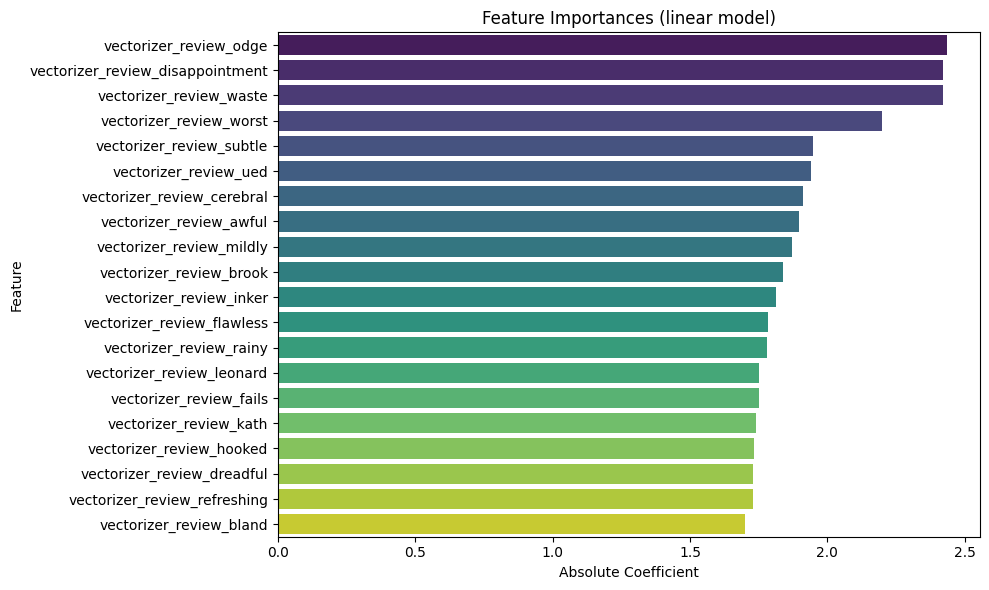

<Figure size 1500x600 with 0 Axes>

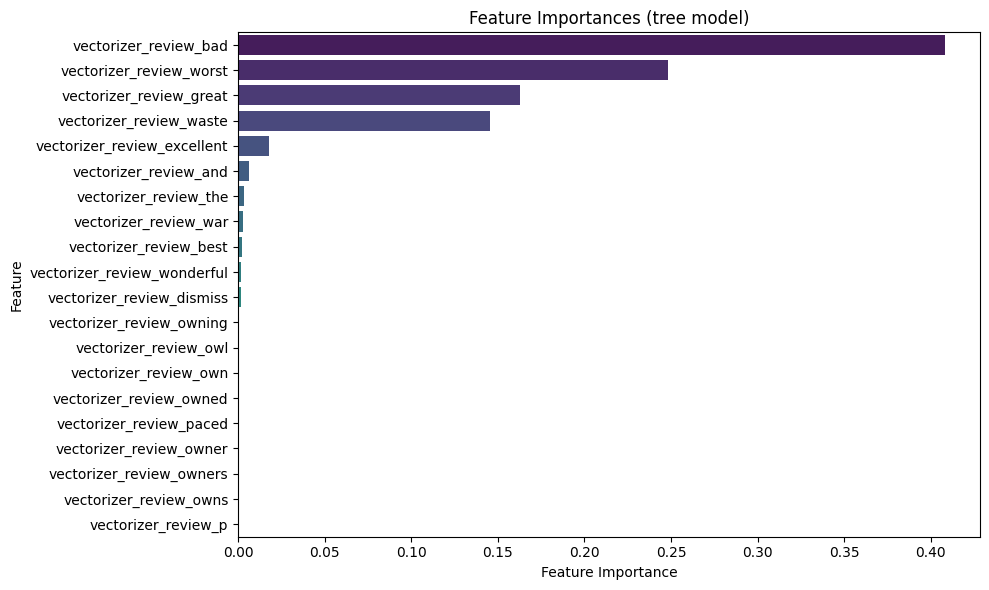

<Figure size 1500x600 with 0 Axes>

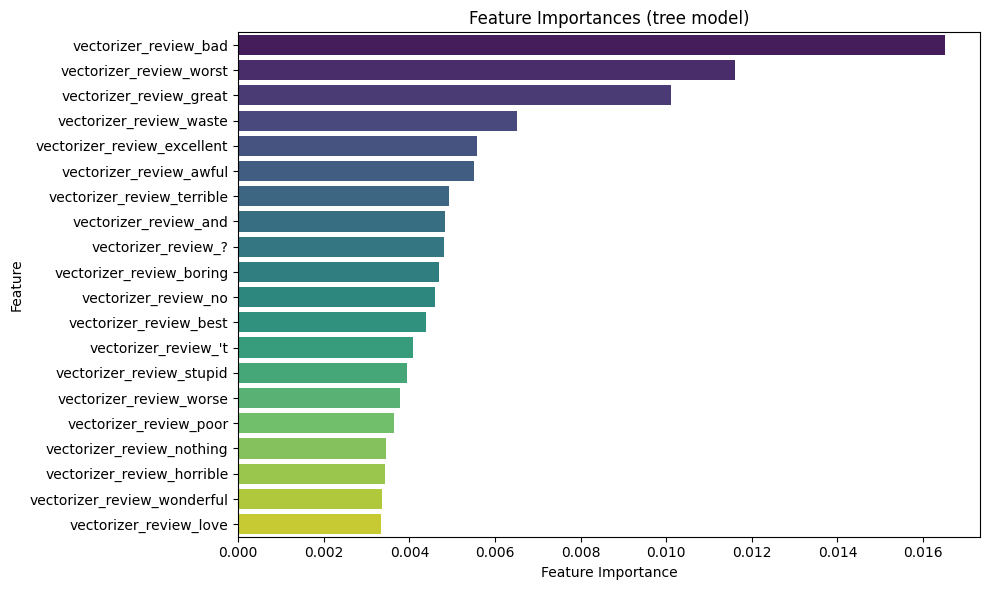

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have va

<Figure size 1500x600 with 0 Axes>

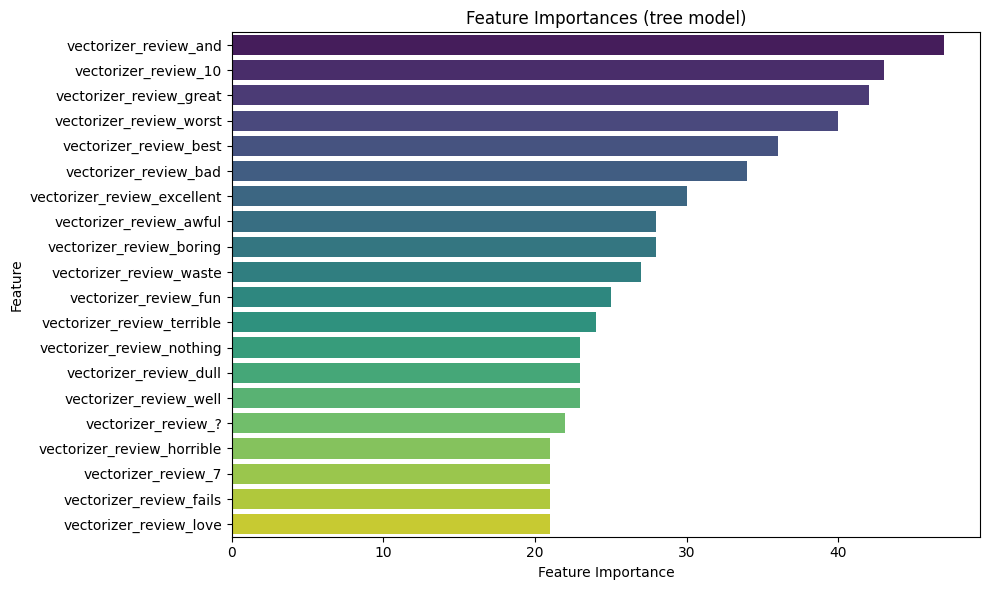

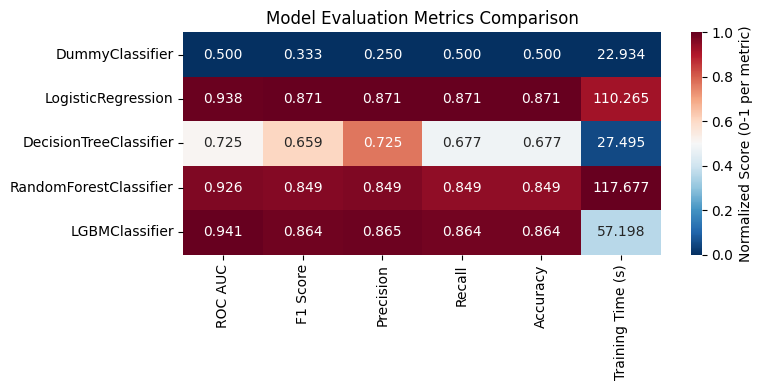

In [16]:
# Обучаем все baseline модели с кросс-валидацией
# Функция автоматически обучает каждую модель, оценивает метрики и строит графики важности признаков
count_vectorizer_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=count_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)

**Анализ важности признаков:**

На графиках feature importance мы видим, что некоторыми из важных фичей стали "the", "and". 

**Вывод:** Хоть классический подход обработки текстов и предписывает удаление знаков препинания, 
в этом случае делать этого не стоит из-за риска потерять важные фичи. 
Можно попробовать удалить стоп-слова.

#### 6.1.2 Удалим стоп-слова

**Логика:** Стоп-слова (артикли, предлоги, союзы) обычно не несут смысловой нагрузки.
Их удаление может улучшить качество модели и ускорить обучение.

In [17]:
# Создаем копию данных для экспериментов с очисткой
X_cleaned_tokens = X.copy()

# Удаляем стоп-слова из токенов, но оставляем пунктуацию
# lowercase_for_counting=True приводит все к нижнему регистру для корректного подсчета
X_cleaned_tokens['review'] = X_cleaned_tokens['review'].map(lambda tokens: filter_tokens(
    tokens, 
    remove_stopwords=True, 
    remove_punct_tokens=False,  # оставляем пунктуацию, так как она информативна
    lowercase_for_counting=True
))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

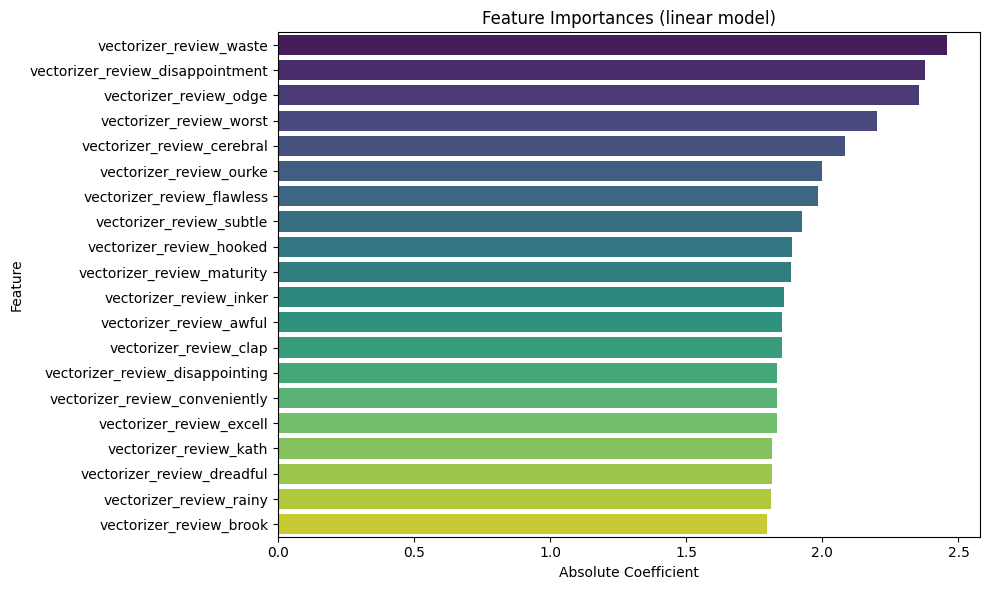

<Figure size 1500x600 with 0 Axes>

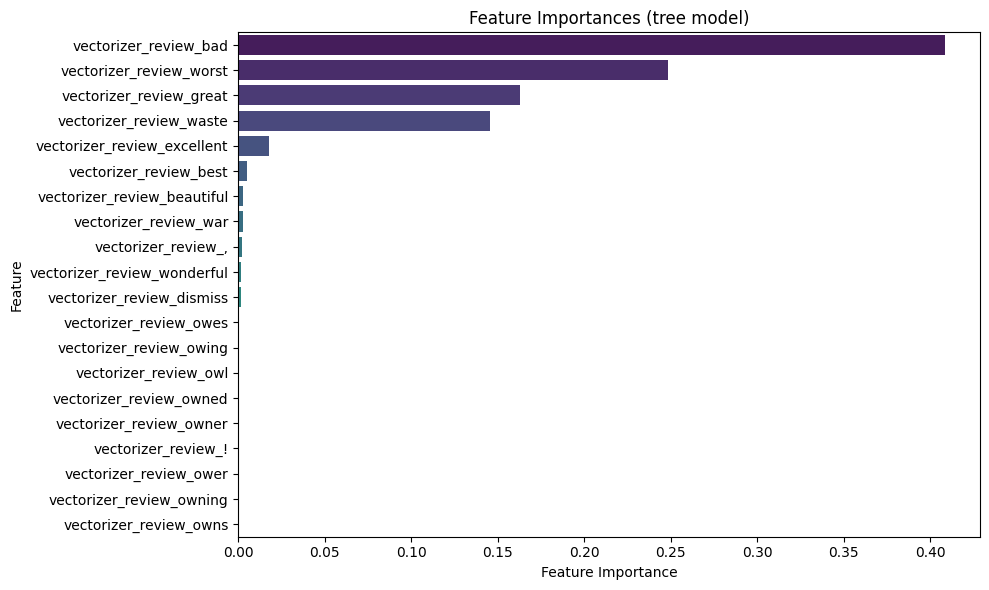

<Figure size 1500x600 with 0 Axes>

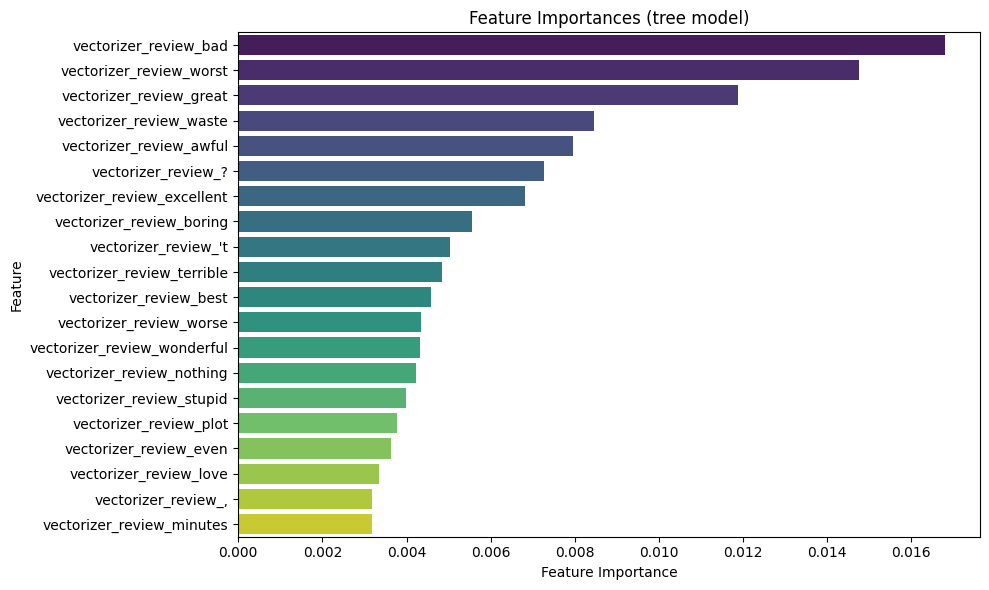

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have va

<Figure size 1500x600 with 0 Axes>

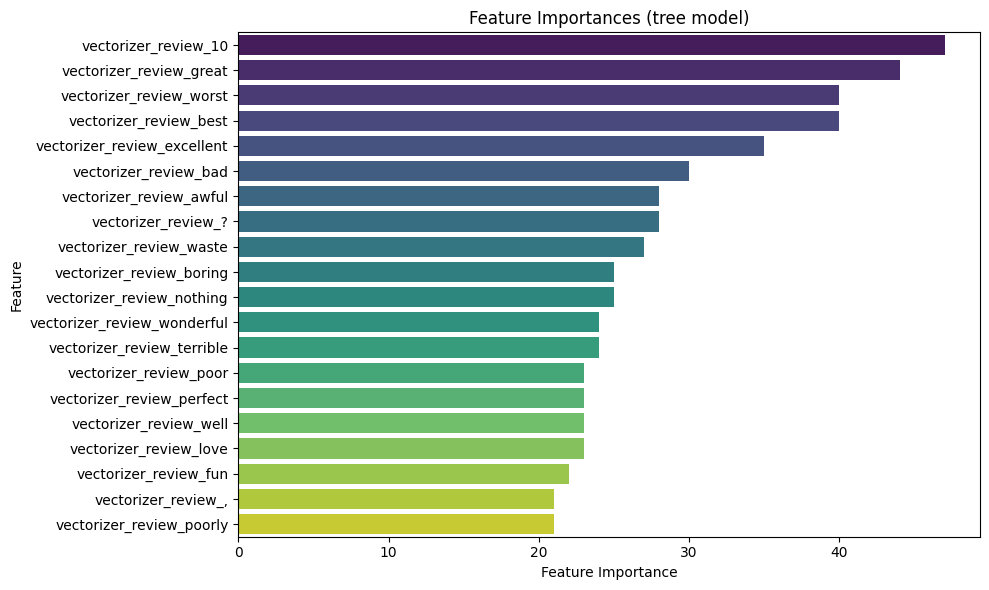

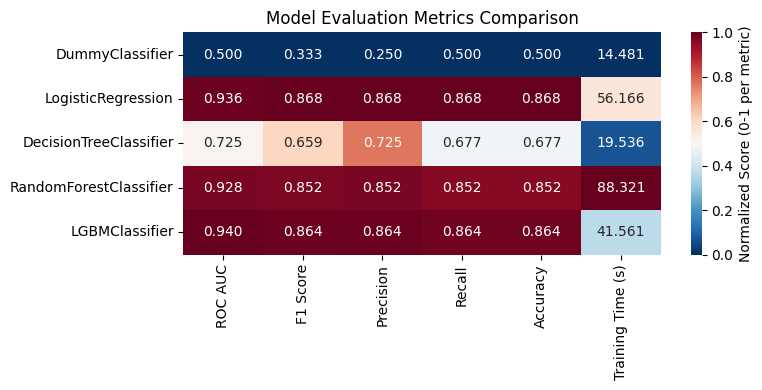

In [18]:
# Обучаем модели на очищенных от стоп-слов данных
# Сравним результаты с предыдущим экспериментом
count_vectorizer_cleaned_metrics = train_evaluate_models_cv(
    models=models,
    X=X_cleaned_tokens,
    y=y,
    preprocessor=count_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)

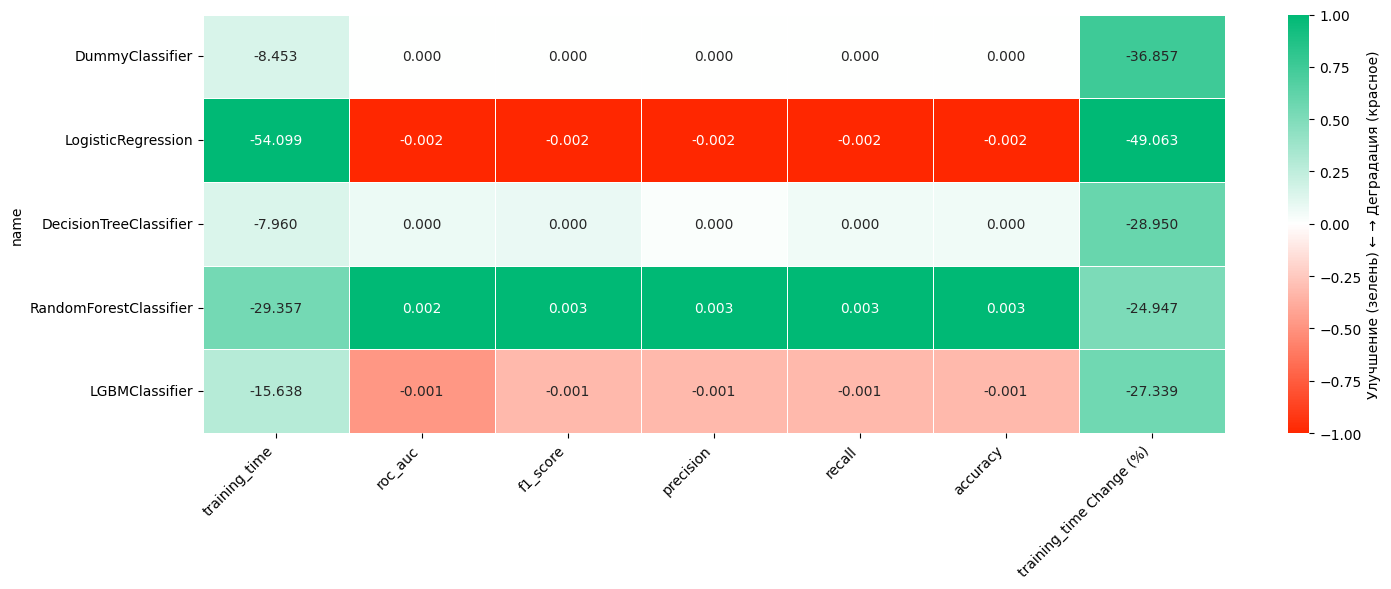

In [19]:
# Сравниваем метрики моделей до и после удаления стоп-слов
# Тепловая карта покажет, улучшилось ли качество после очистки
compare_metrics_heatmap(count_vectorizer_metrics, count_vectorizer_cleaned_metrics);

**Вывод по удалению стоп-слов:**

Изменение метрик незначительное, но наблюдается значительное ускорение времени обучения от 15 до 50 процентов.
Это преобразование оставим, так как:
1. Ускоряет обучение без потери качества
2. Стоп-слова в наших текстах не несут дополнительной смысловой нагрузки
3. Уменьшает размерность признакового пространства

#### 6.1.3 Топ 100 важных токенов

**Логика:** Вместо использования всех токенов, выбираем только самые важные для классификации.
Это может улучшить качество линейных моделей и ускорить обучение.

In [20]:
# Создаем пайплайн с отбором топ-100 важных токенов
count_vectorizer_important_tokens_preprocessor = Pipeline([
    (
        'columns',
        ColumnTransformer([
            # Пайплайн для описаний: сначала отбираем важные токены, потом векторизуем
            (
                'review_pipeline',
                Pipeline([
                    ('token_selector', NgramFeatureSelector(top_k=100)),
                    ('vectorizer', CountVectorizer(analyzer=lambda x: x, min_df=50,max_df=0.9, dtype=np.float32)),
                ]),
                'review'
            ),
        ],
            verbose_feature_names_out=True
        )
    ),
])

In [21]:
#Сократим треничровочную выборку до 40%
ratio = 0.4
X_red, X_residual, y_red, y_residual = train_test_split(X, y, random_state = SEED, stratify = y, train_size = ratio)

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

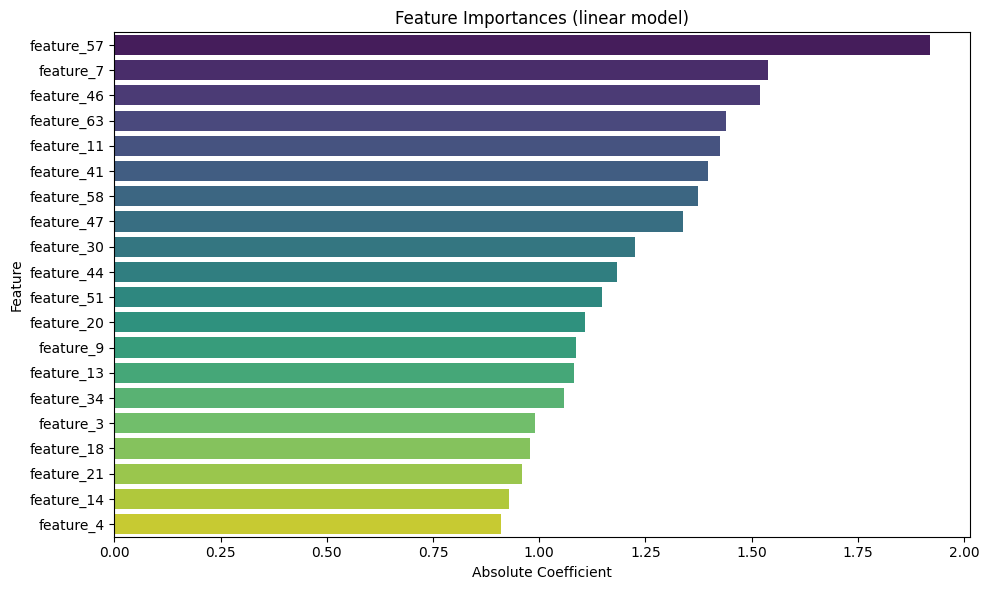

<Figure size 1500x600 with 0 Axes>

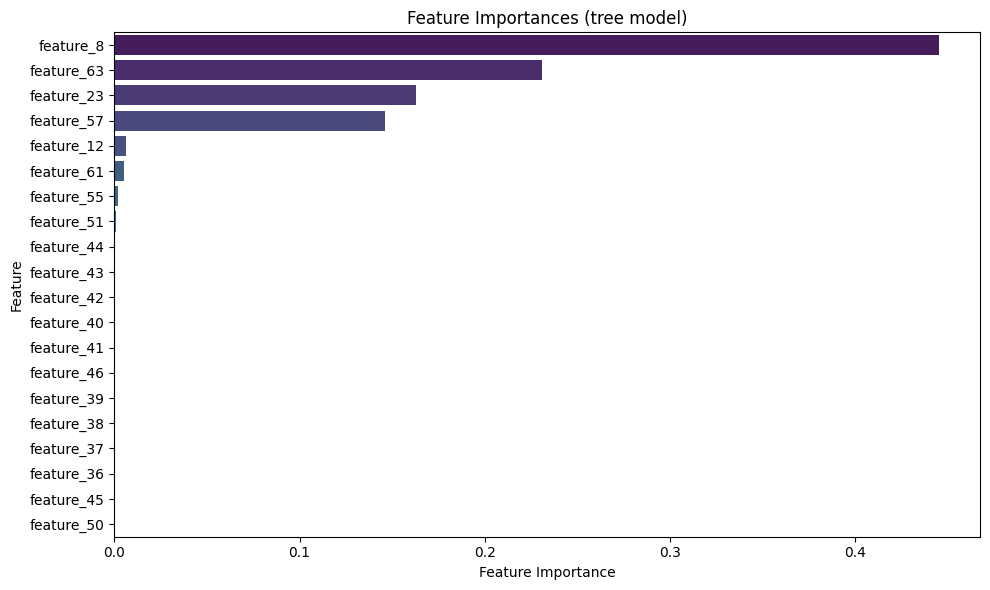

<Figure size 1500x600 with 0 Axes>

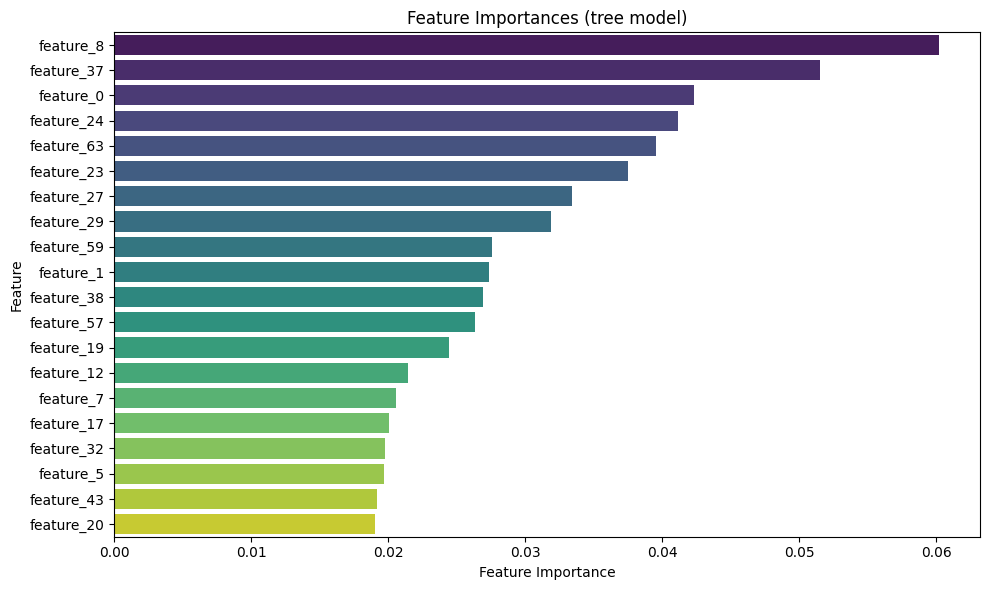

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have va

<Figure size 1500x600 with 0 Axes>

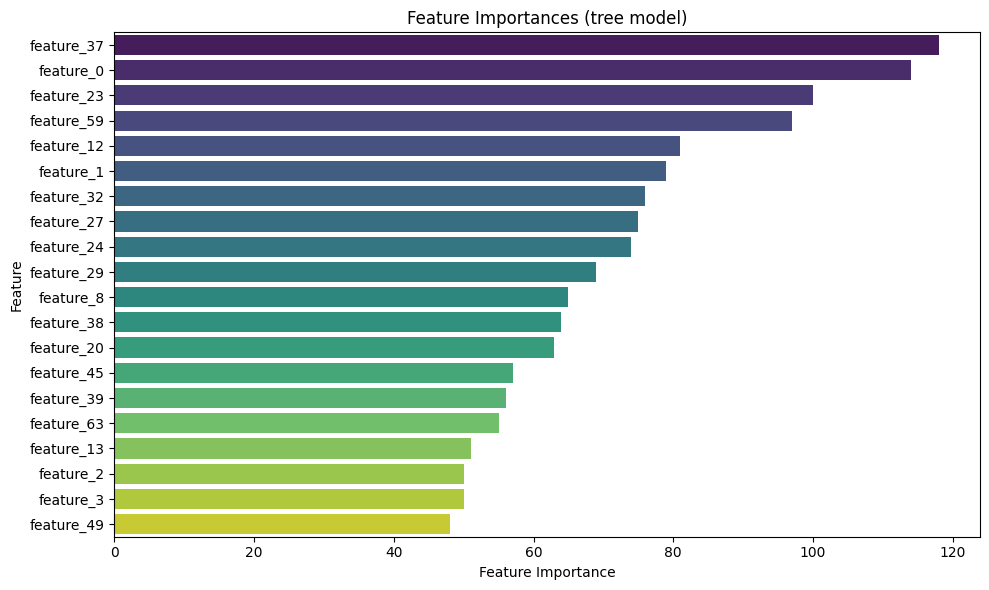

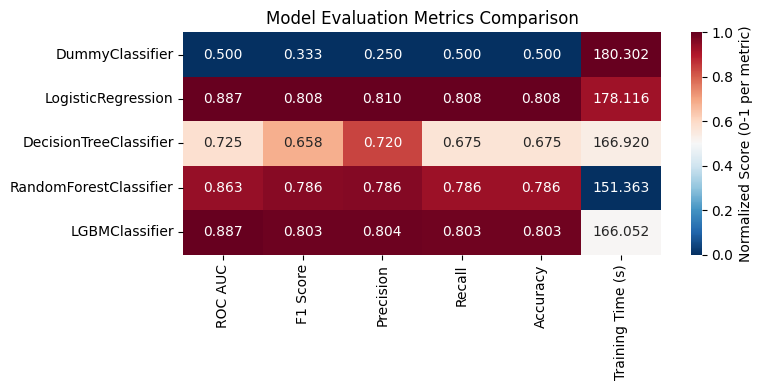

In [22]:
# Обучаем модели с отбором важных токенов
# Используем исходные данные (не очищенные от стоп-слов), так как отбор токенов делается на основе важности
count_vectorizer_important_tokens_metrics = train_evaluate_models_cv(
    models=models,
    X=X_red,
    y=y_red,
    preprocessor=count_vectorizer_important_tokens_preprocessor,
    cv=cv,
    seed=SEED
)

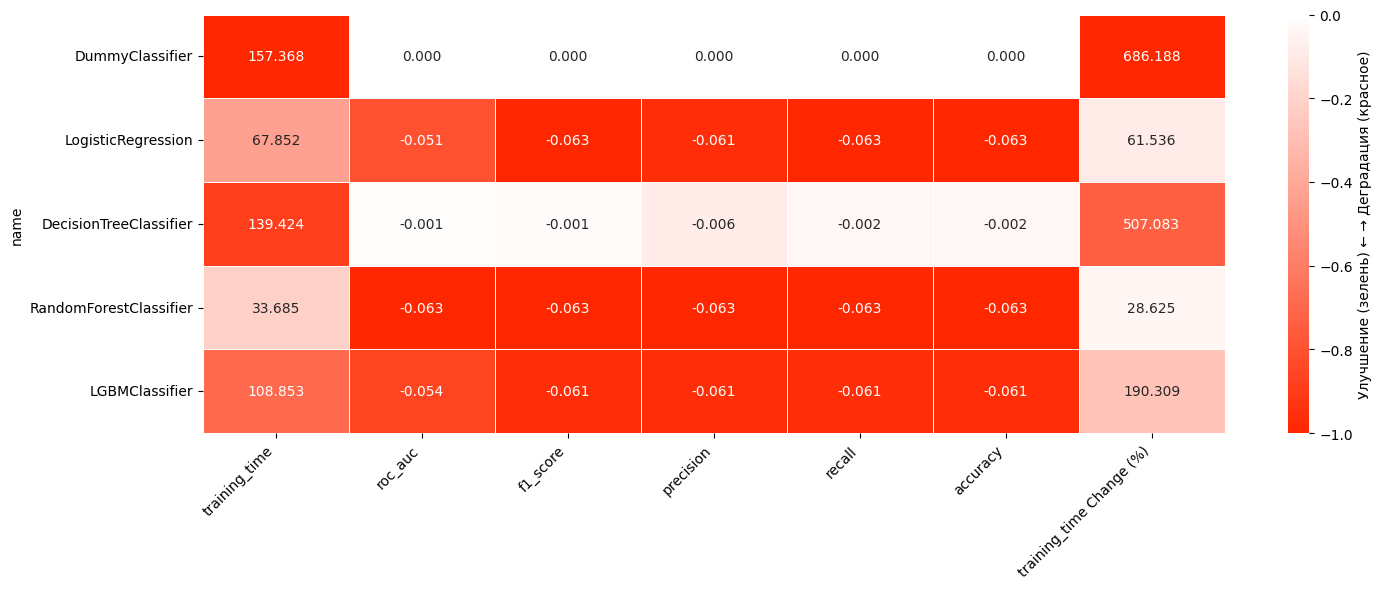

In [23]:
# Сравниваем результаты с отбором важных токенов и без него
compare_metrics_heatmap(count_vectorizer_metrics, count_vectorizer_important_tokens_metrics);

**Вывод по отбору важных токенов:**

Заметно значимое ухудшение для всех ансамблей и логистической регрессии. Помимо этого, даже на 40% выборки выремя выросло от +48 до 83 процентов. Возможно, обучение на 80-100% выборки дало бы плоды, но времязатраты были бы гигансткими и инференс на текущем GPU невозможен.

**Проблемы:**
- Сильно увеличилось время обучения за счет долгого пересчета n-грамм
- Улучшение качества отсутствует, только ухудшение
**Рекомендация:** Применять такое преобразование имеет смысл только на больших мощностях и для линейных моделей, так как деревья и так отбирают признаки, особенно случайный лес.

#### 6.1.4. Удаление HTML-тегов
Логика: В тексте было найдено немало html тегов, которые часто токенизируются отдельно. Попробуем их удалить, так как они не должны быть информативны.

In [24]:
df_no_html = df.copy()

df_no_html['is_positive'] = df_no_html['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df_no_html = df_no_html.drop(columns = 'sentiment')
df_no_html['review'] = df_no_html['review'].apply(remove_html_tags)
df_no_html['review'] = df_no_html['review'].apply(tokenize_tiktoken)
X_no_html, y_no_html = divide_data(df_no_html, 'is_positive')

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

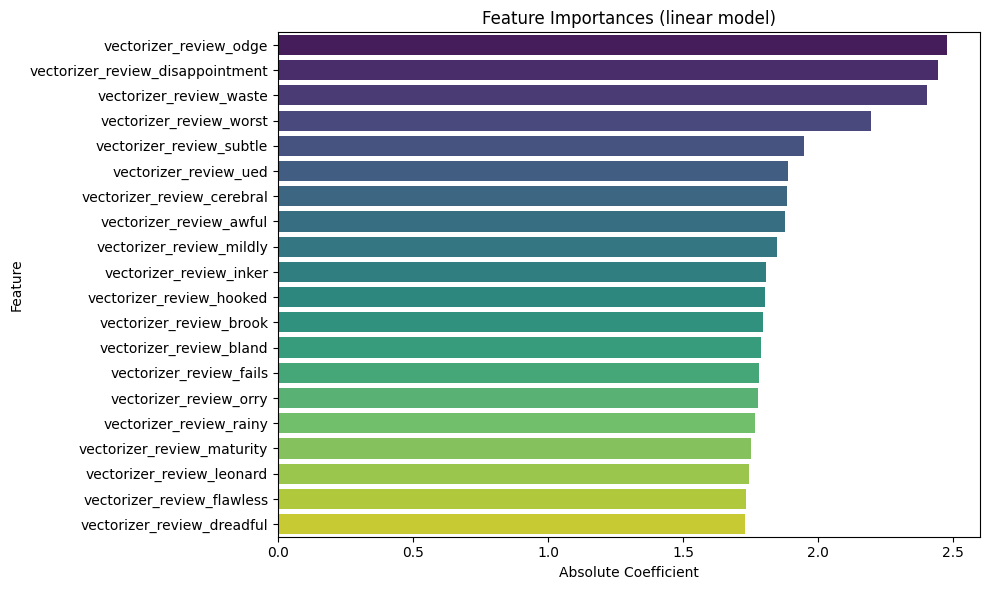

<Figure size 1500x600 with 0 Axes>

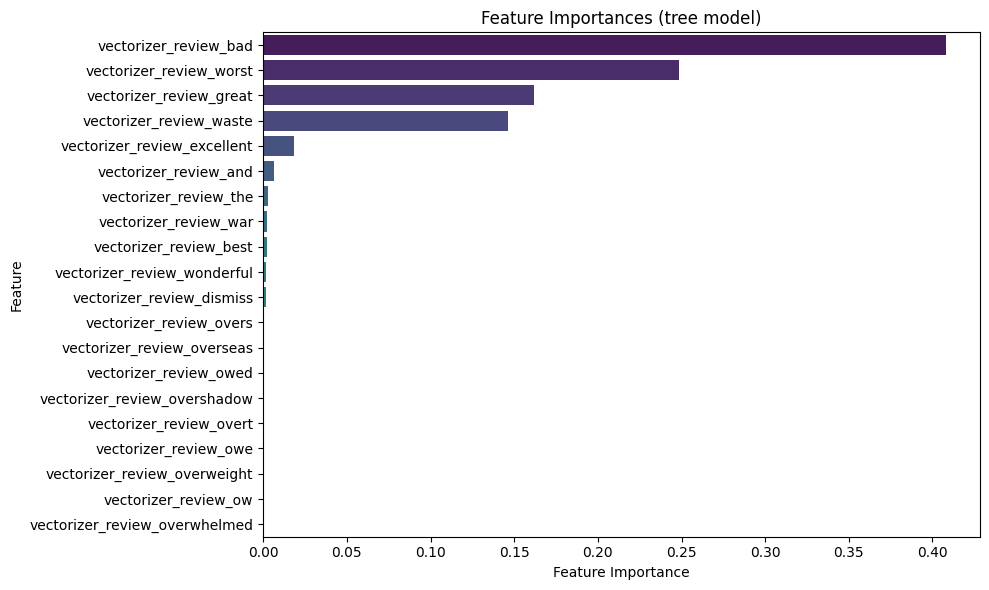

<Figure size 1500x600 with 0 Axes>

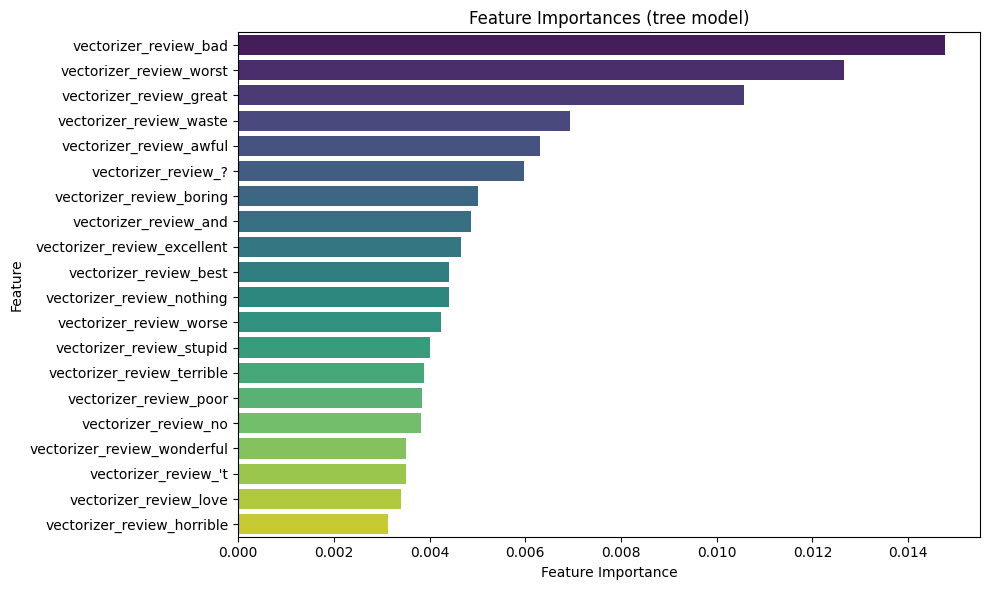

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have va

<Figure size 1500x600 with 0 Axes>

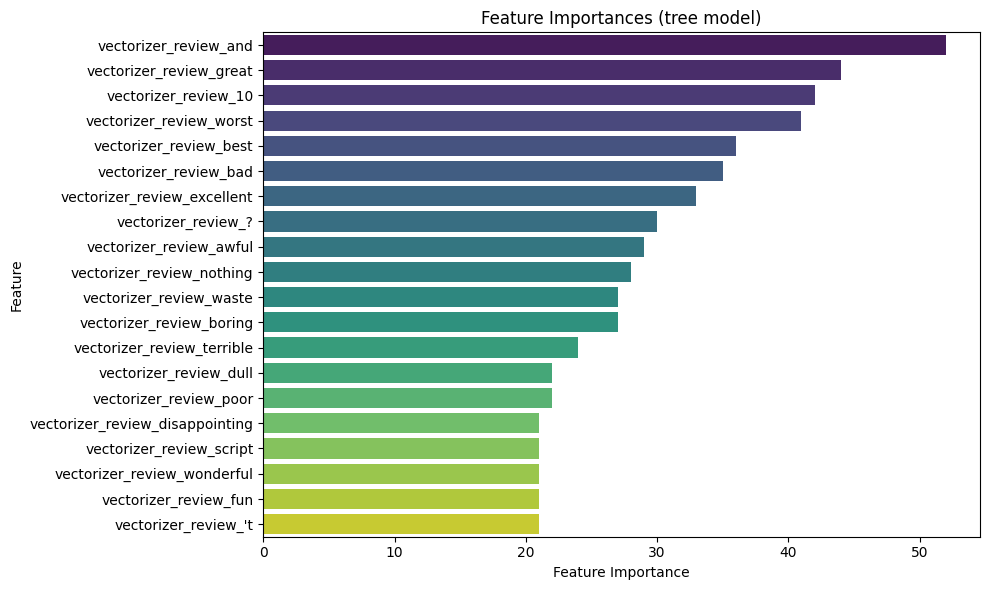

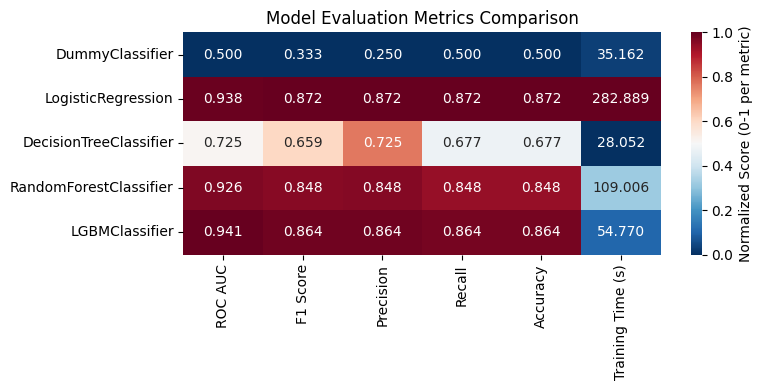

In [28]:
#Обучаем модели с предварительным удалением html тегов
count_vectorizer_no_html_metrics = train_evaluate_models_cv(
    models=models,
    X=X_no_html,
    y=y_no_html,
    preprocessor=count_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)

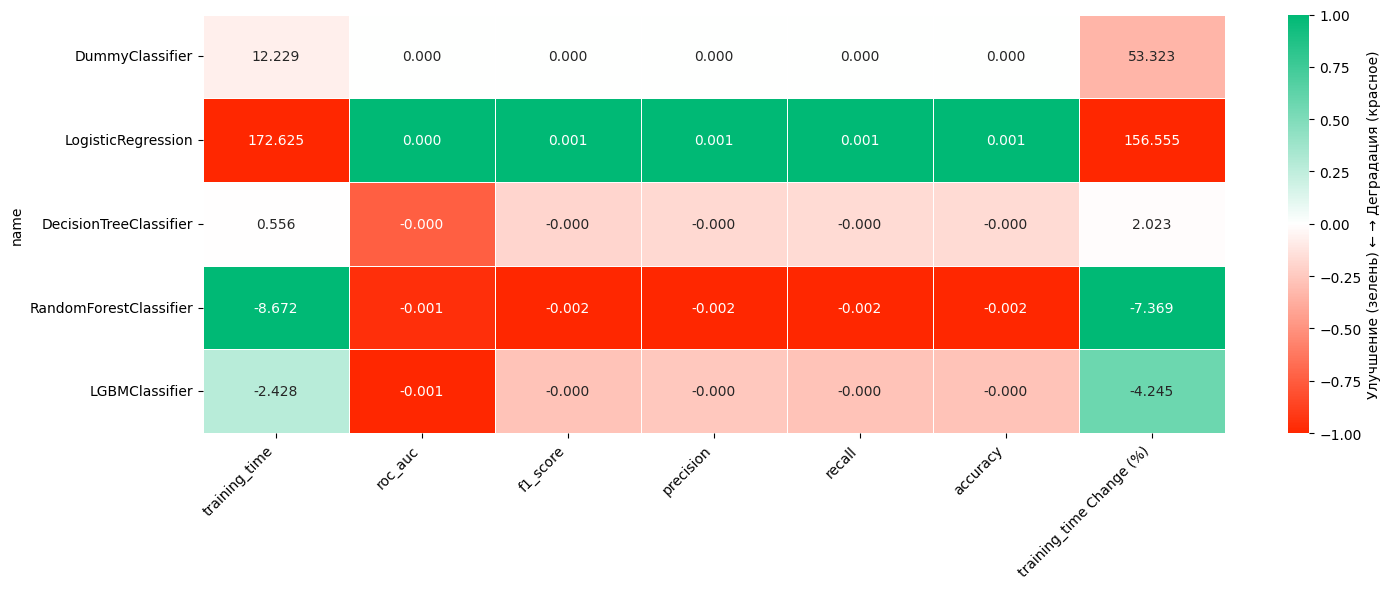

In [29]:
compare_metrics_heatmap(count_vectorizer_metrics, count_vectorizer_no_html_metrics);

**Вывод по удалению html тегов:**

Время на обучение в основном уменьшилось при сохранении всех показателей.

**Рекомендации**

Применять только для бустинга

### 6.2. TfidfVectorizer

**Логика:** TF-IDF (Term Frequency-Inverse Document Frequency) учитывает не только частоту слова в документе,
но и редкость слова в корпусе. Это может дать лучшие результаты, чем простой подсчет частот.

#### 6.2.1 Без очистки токенов

**Цель:** Проверить базовое качество TF-IDF векторизации с исходными токенами.

In [30]:
# Создаем пайплайн для TF-IDF векторизации
tfidf_vectorizer_preprocessor = Pipeline([
    ('review', ColumnTransformer(
        [
            # TF-IDF векторизация описаний: min_df=50 исключает редкие слова
            ('review_vectorizer', TfidfVectorizer(analyzer=lambda x: x, min_df=50, dtype=np.float32), 'review')
        ],
        remainder='drop', 
        verbose_feature_names_out=True
    )),
])

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

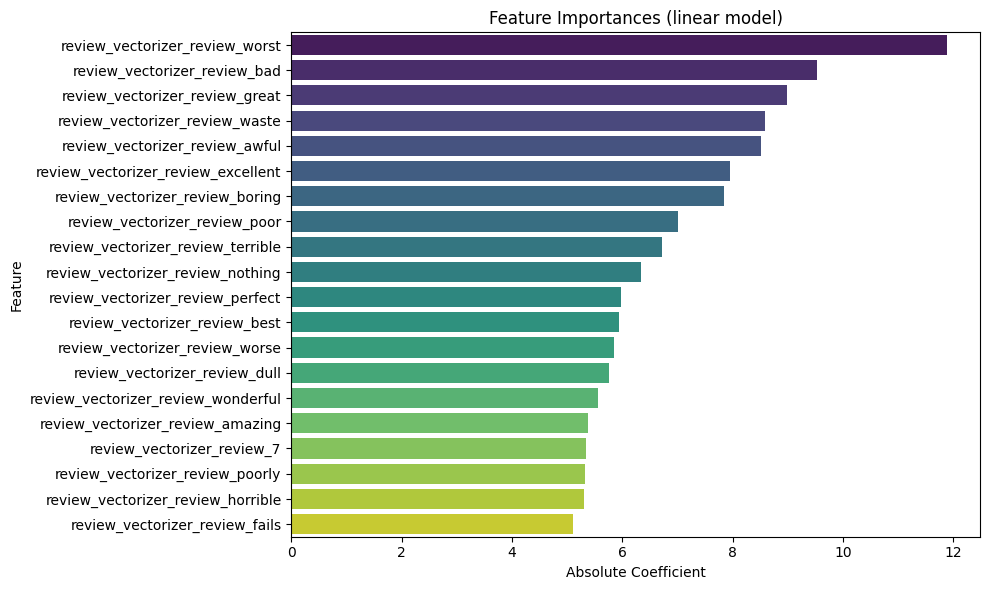

<Figure size 1500x600 with 0 Axes>

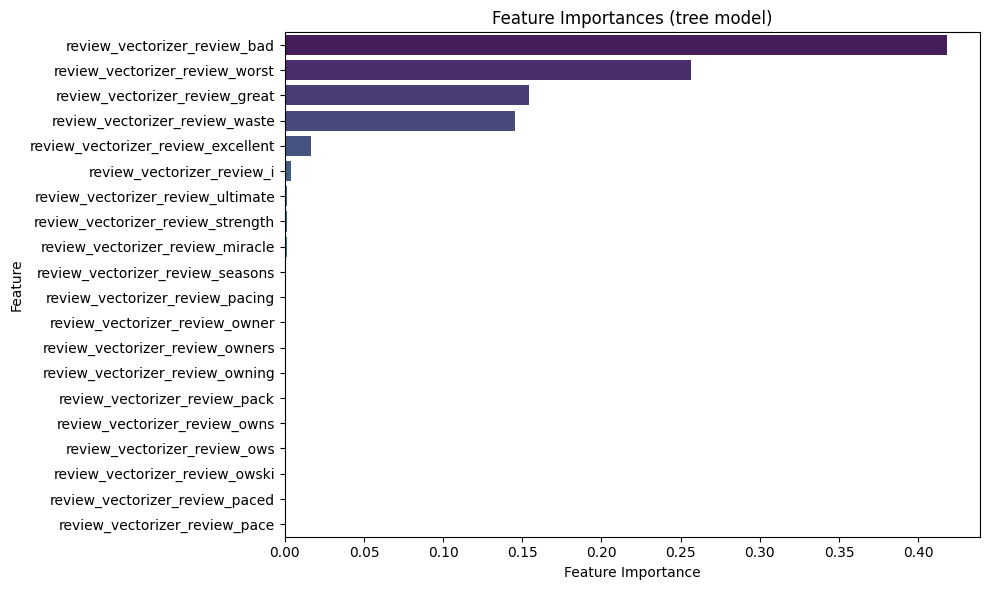

<Figure size 1500x600 with 0 Axes>

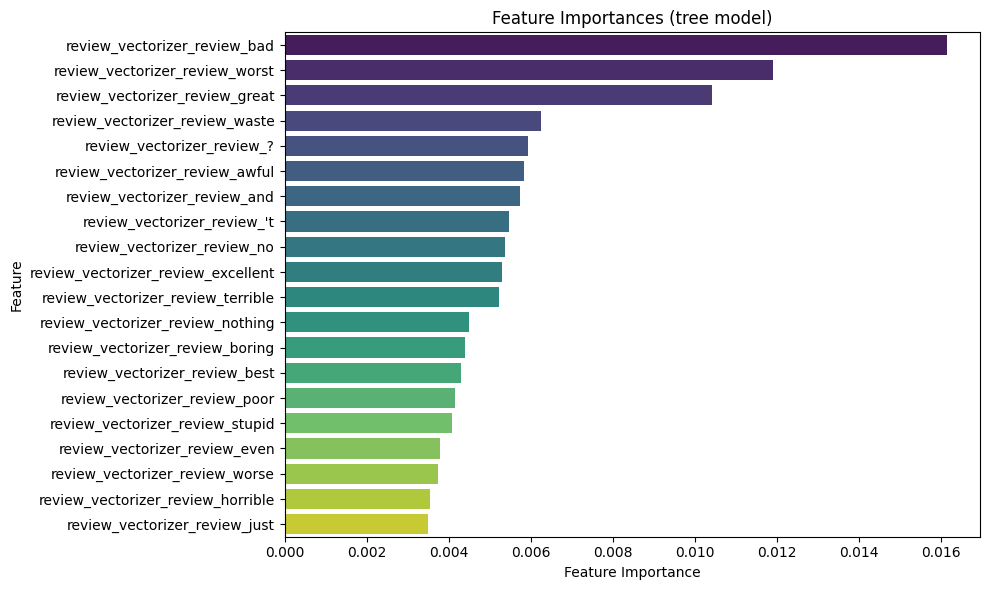

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have va

<Figure size 1500x600 with 0 Axes>

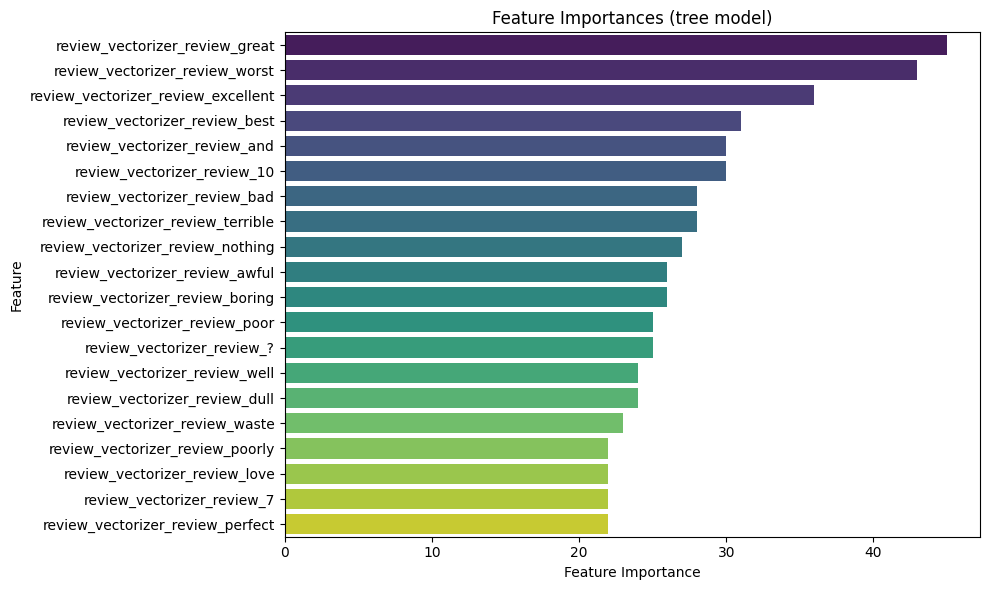

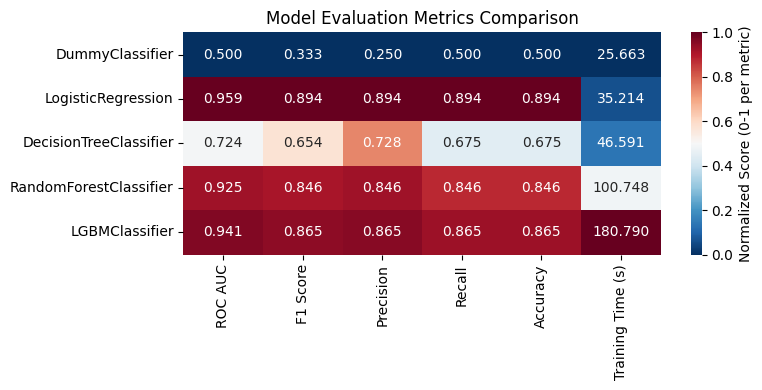

In [31]:
# Обучаем модели с TF-IDF векторизацией на исходных данных
tfidf_vectorizer_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=tfidf_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)

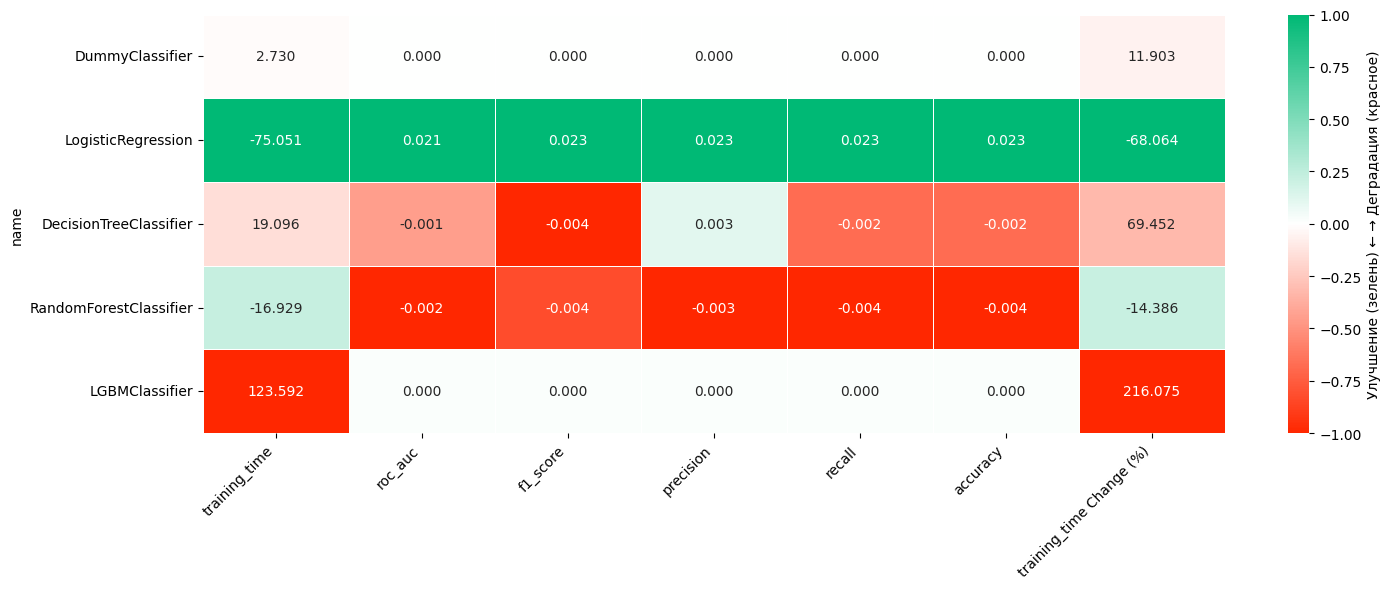

In [32]:
# Сравниваем CountVectorizer и TfidfVectorizer
compare_metrics_heatmap(count_vectorizer_metrics, tfidf_vectorizer_metrics);

**Выводы**

Незначительное изменение качества в целом, но большие плюсы для логистической регрессии. Время для деревьев выросло. Имеет смысл применять для логистической регрессии.

#### 6.2.2 Удаление стоп-слов

**Цель:** Проверить, улучшится ли качество TF-IDF после удаления стоп-слов.

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

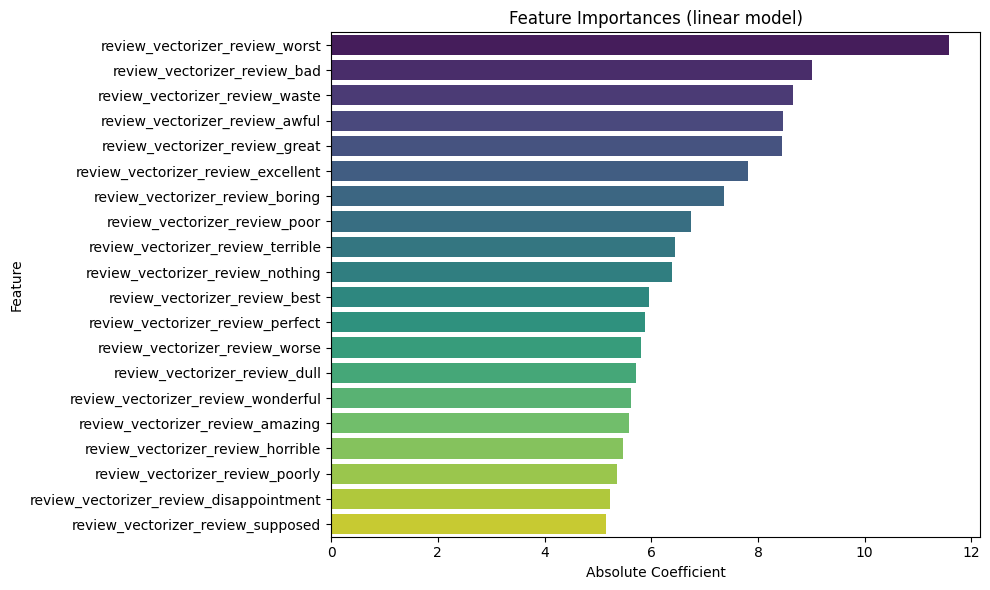

<Figure size 1500x600 with 0 Axes>

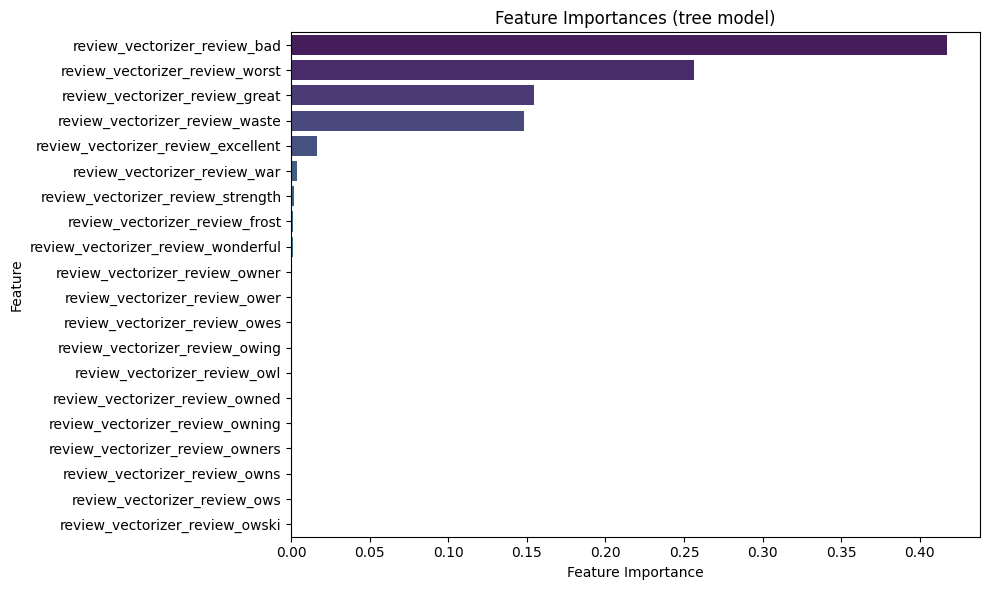

<Figure size 1500x600 with 0 Axes>

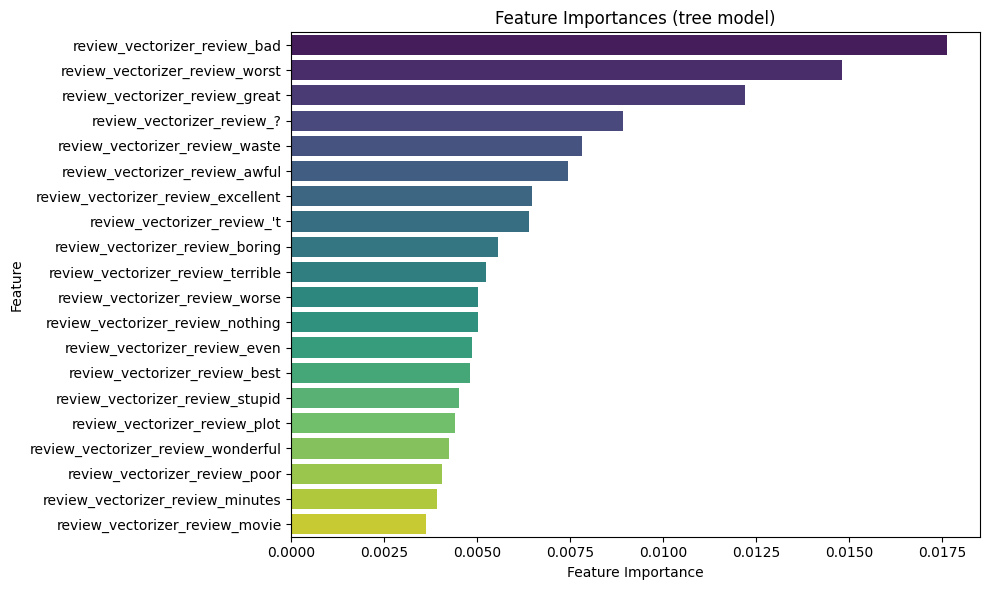

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have va

<Figure size 1500x600 with 0 Axes>

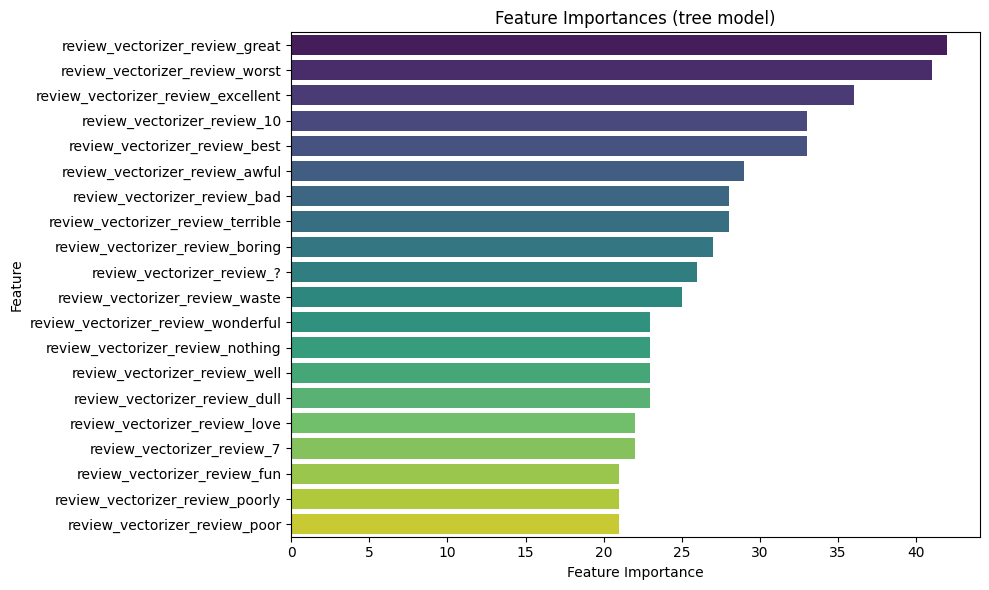

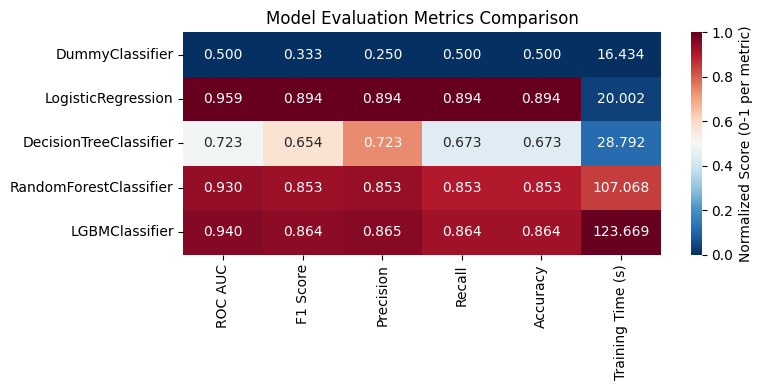

In [33]:
# Обучаем TF-IDF модели на данных без стоп-слов
tfidf_vectorizer_clean_metrics = train_evaluate_models_cv(
    models=models,
    X=X_cleaned_tokens,
    y=y,
    preprocessor=tfidf_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)

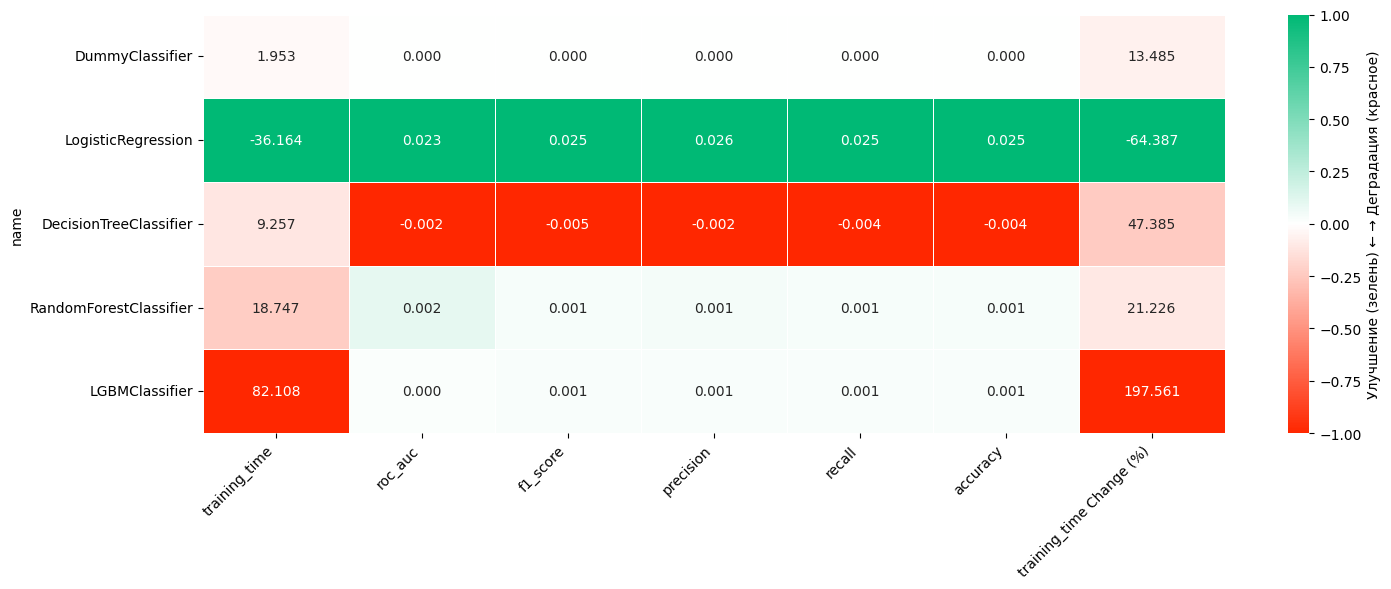

In [34]:
# Сравниваем CountVectorizer и TfidfVectorizer на очищенных данных
compare_metrics_heatmap(count_vectorizer_cleaned_metrics, tfidf_vectorizer_clean_metrics);

#### 6.2.3 Удаление HTML тегов

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

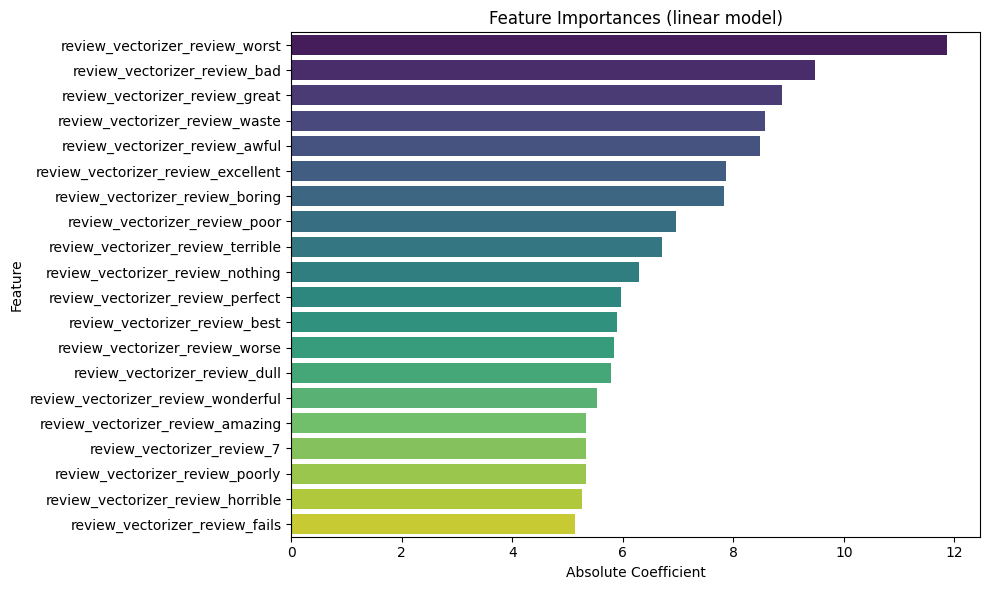

<Figure size 1500x600 with 0 Axes>

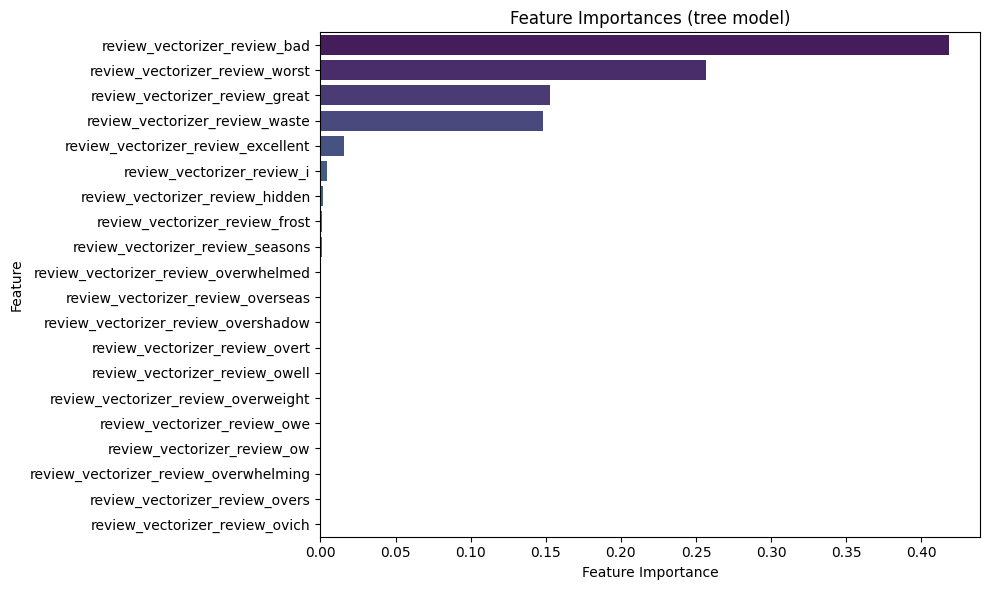

<Figure size 1500x600 with 0 Axes>

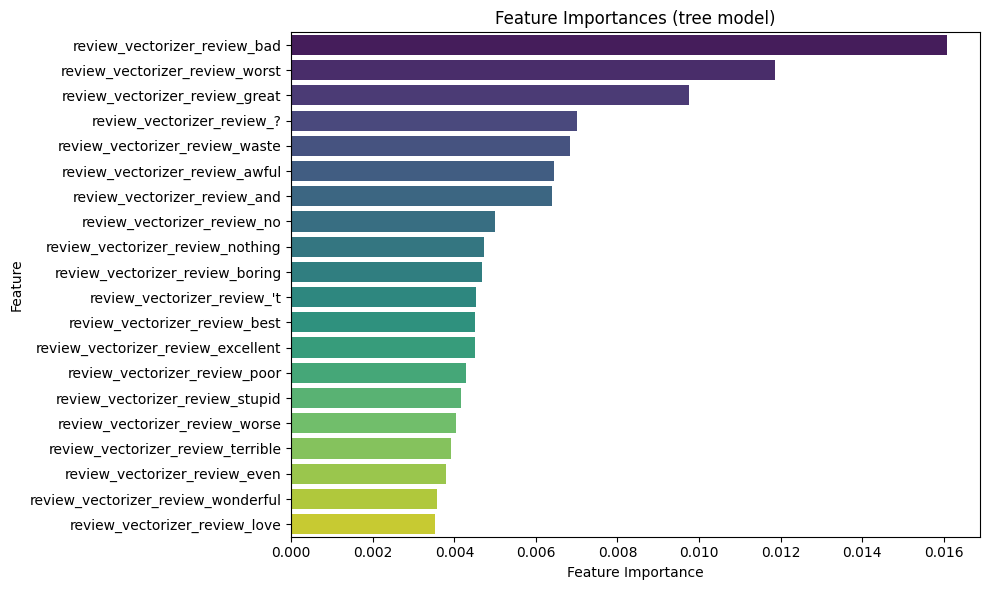

/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/user/классификация_Богдан/lova/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have va

<Figure size 1500x600 with 0 Axes>

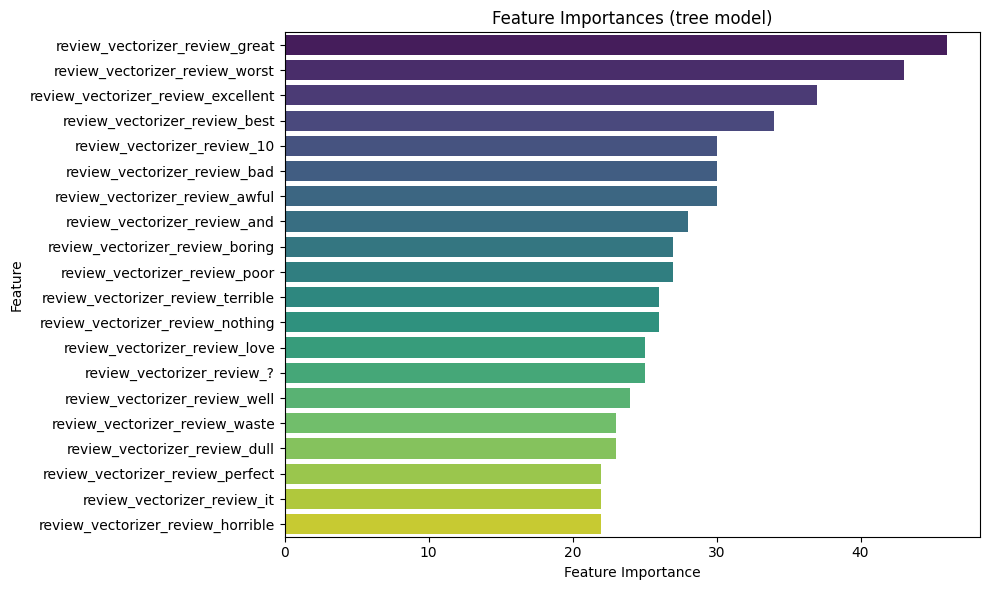

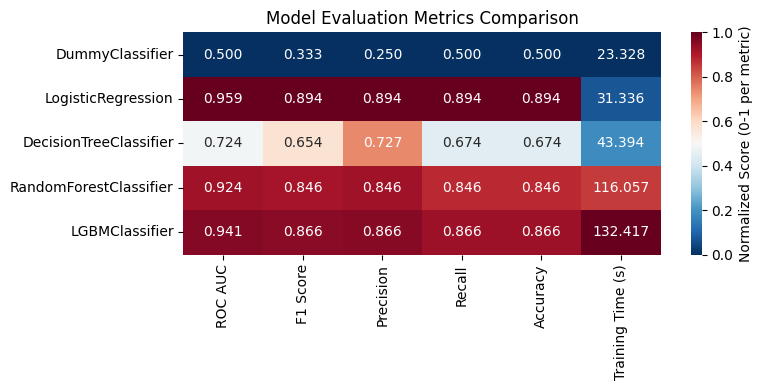

In [35]:
tfidf_vectorizer_no_html_metrics = train_evaluate_models_cv(
    models=models,
    X=X_no_html,
    y=y_no_html,
    preprocessor=tfidf_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)

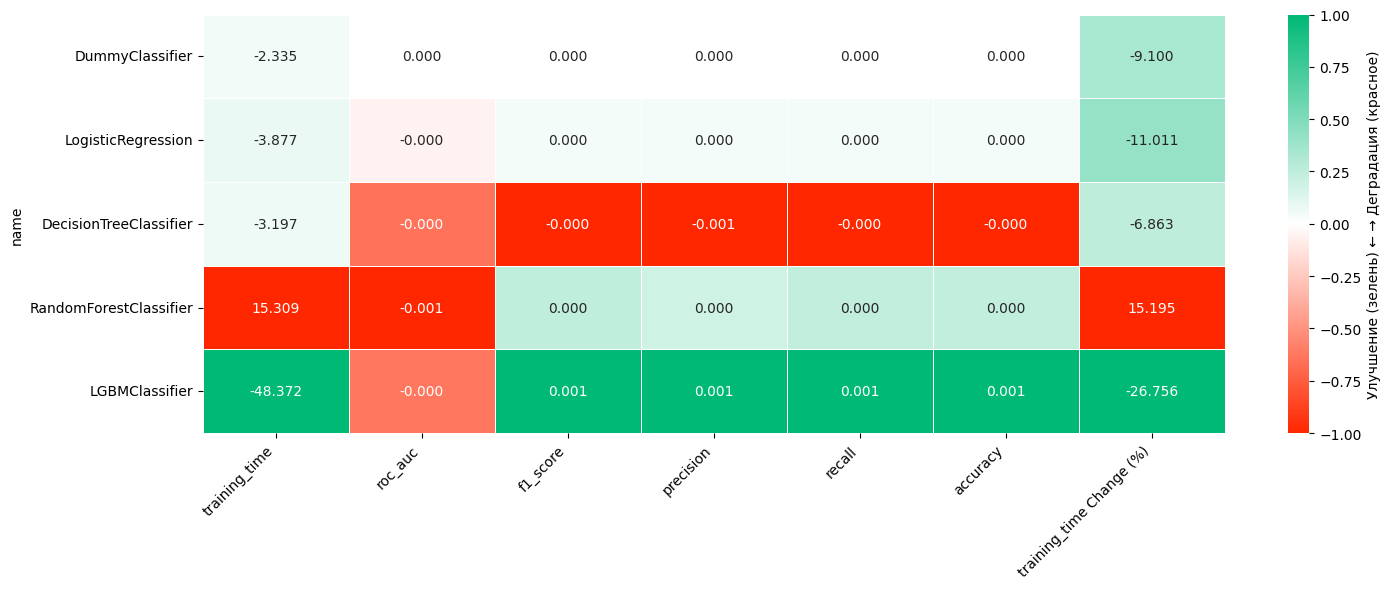

In [36]:
compare_metrics_heatmap(tfidf_vectorizer_metrics, tfidf_vectorizer_no_html_metrics);

**Выводы**:
Заметных улучшений метрик нет, при этом чуть-чуть уменьшилось время обучения.

Однако мы не учитываем время на очистку текста от тегов -- значит не так очевидна временнАя выгода и не будем использовать.

### 7. Выводы по baseline моделям

**Лучший результат:** Логистическая регрессия показала лучшие accuracy и f1 при минимальном времени с tf-idf с очисткой стоп слов. Очень хорошо для инференса, даже нет tradeoff между чем либо.

**Ключевые находки:**
1. **CountVectorizer vs TfidfVectorizer:** CountVectorizer показал лучше результаты для деревьев, tf-idf для линейной модели (логистическая регрессия)
2. **Удаление стоп-слов:** Ускоряет обучение при таком же и лучшем качестве
3. **Отбор важных токенов:** Может помочь только линейным моделям, но неприменим в силу размерности данных. На урезанной выборке не показал себя.
4. **Удаление html тегов** Не принесло существенной выгоды во времени и не изменило метрики.

### План дальнейшего развития

**Улучшения предобработки:**
- убрать отдельно стоп-слова и html теги

**Классические подходы к векторизации:**
- Count vectorizer (частота вхождения каждого токена в текст) ✅
- TFIDF vectorizer ✅
- HashingVectorizer

**Нейросетевые подходы:**
- кастомная нейросеть (RNN)
- кастомная нейросеть (LSTM) 
- кастомная нейросеть (CNN)
- pre-trained эмбеддинги для слов (GloVe и другие)
- предобученные модели с классификацией (transformers, BERT)

**Гибридные подходы:**
- эмбеддинги из обученных ранее моделей
- эмбеддинги из предобученных моделей (transformers, BERT)
- OpenAI эмбеддинги (и другие LLM)

**Улучшения токенизации:**
- другие более умные токенизаторы
- учет domain specific слов
- удаление стоп-слов и знаков препинания
- оставить только топ-x токенов по метрике
- удалить токены с высокой корреляцией